# Importing the neccessary dependencies

In [577]:
import pandas as pd
import numpy as np
import os
from textblob import TextBlob
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 

from sklearn.linear_model import LogisticRegression

import model_evaluation_utils as meu 


pd.options.display.max_colwidth = 200
%matplotlib inline

# Neccessary Functions:

In [578]:
# -*- coding: utf-8 -*-
"""
the contents of this cell
can be saved as model_evaluation_utils.py
and imported with the line

import model_evaluation_utils as meu 

"""

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
                        

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                labels=level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)
    

def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1]-1] 
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        
        fpr, tpr, _ = roc_curve(y_test, y_score)      
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)
        
    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(label, roc_auc[i]), 
                     linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    #plt.legend(loc="lower right")
    plt.show()
    
# -------

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
# our pipeline is ready

# 1. DATA WRANGLING AND CLEANING

first we load in all our data through pandas

In [580]:
path1 = '/Users/Alexandra/Desktop/REPOS/Springboard_DS/CAPSTONE_2/CAP_2/gtd_95to12_0617dist.csv'

df = pd.read_csv(path1, encoding = "ISO-8859-1") #learn for later

/Users/Alexandra/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,6,33,61,62,63,76,79,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [581]:
path = '/Users/Alexandra/Desktop/REPOS/Springboard_DS/CAPSTONE_2/CAP_2/gtd_13to16_0617dist3.csv'

df1 = pd.read_csv(path, encoding = "ISO-8859-1") #learn for later

/Users/Alexandra/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,20,21,22,23,25,26,27,28,30,32,33,34,36,40,42,44,48,50,51,52,53,54,55,56,57,61,62,63,65,66,67,68,69,70,71,72,74,75,76,77,78,79,80,81,83,85,87,89,91,93,94,95,96,98,99,100,101,102,103,104,105,107,109,110,111,112,113,114,115,116,117,118,119,120,121,122,124,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,303,

#### why do we decide to only read in the two most recent ?

according to GDT https://www.start.umd.edu/gtd/downloads/Codebook.pdf the "doubtterr" key is only available after 1997, also we feel that the groups change a bit frequently over the years and do not last very long so possibly just the recent two datasets are neccessary. 

Based on some reliable sources, we can understand the average "life-span" of a terrorist group. If we want to build a model that is good at predicting which categorizes a "new terrorist attack" or a terrorist attack that occurs some time after this date. If thats then data from the 1980's and 1870's would probably impede on the models ability to accuratley accuratley predict new data.

##### of course, thats assuming that we want to use our model to predict NEW attacks, what if we want to attribute an old attack from the 1970's to a certain group or organization?? in that case, here's what we do.
If what we  we want to predict the responsible terrorist group from an older, yet a still unkown attack, (for example, an attack from 1975) then we can load in the relevant data from the 1970's and train our model on a chunk of data spanning the 1970's to early 2000's. When we load in that time span of data, we can then train our model on the data from that relevant time period.

The assumtion can be made given the nature of terrorsit organizations and knowing the average life span of them to be shorter than 20 years, links to corroborate this claim can be found: https://ctc.usma.edu/how-terrorist-groups-end/ and https://www.tandfonline.com/doi/abs/10.1080/13523260903326602?journalCode=fcsp20

The bias of a source should be examined always, but especially when asessing the validity of sources on emotionally charged subject matter such as the topic of terrorism. Though considering we are only investigating the life span of a terrorist group, that information should not be biased in a way that would work against us, if anything, the average group life-span given by a biased would be most likely be "legnthened". 

In [582]:
Counter(type(item) for item in df['summary']),Counter(type(item) for item in df1['summary'])

(Counter({float: 9263, str: 45792}), Counter({str: 56386}))

Upon loading the data we checked the type of df['summary'] and df1['summary'] with Counter from the collections module. For soome initial preprocessing, Below we use a method to replace all the NaNs with a simple white space. 

In [583]:
summary_list = []

for item in df['summary']:
    if type(item) == float:
        item = ''
    summary_list.append(item)

In [584]:
len(summary_list), len(df) # checking the length to assign one to the other

(55055, 55055)

In [585]:
df['summary'] = summary_list

now we need to check out the consistency of our columns if we plan to eventually merge these two dataframes together

In [586]:
print(len(df.columns))
print(len(df1.columns))

135
824


below we are checking: up to what point are the column names infact the same?

In [587]:
# true / false
print(list(df1.columns[0:135]) == list(df.columns[0:135]))
print(list(df1.columns[0:134]) == list(df.columns[0:134]))
print(list(df1.columns[0:133]) == list(df.columns[0:133]))

False
False
True


we see at about 133 the columns are the same. Luckily on our third try we got a match, but if this step required more iterations, this step could have been put into a for loop for more automative checking.

below we filter the columns that are identical from both df, and df1, and we then we append

In [588]:
df = df.filter(items = list(df.columns[0:133]))
df1 = df1.filter(items = list(df.columns[0:133]))
df = df.append(df1)

Finally, in order to ensure our training set is trained in data that has the highest integrity, we want to eliminate any rows from the dataframe that have doubtterr varible equal to 1. This data variable is an indicator of 0 or 1 representing if there is any doubt that the event is considered terrorism or not. As well, since we are constructing our Training/Testing set, we need to eliminate the rows of the dataframe that have unkown labels, since you cannot train or test a model on data with unkown labels.

In [589]:
df = df[df['doubtterr'] == 0]
df = df[df['gname'] != 'Unknown']
df = df.reset_index(drop = True)
len(df)

34115

# 2. EDA

formatting some values from our dataframe into lists, to load it into plots for EDA. The value_counts method returns the instance number of a certain label, this (can be done over any iterable), and then returns a list in which it is sorted in descending order.

In [590]:
gname_list = list(df['gname'].value_counts().index)    # wrapping the total names in a list
value_list = df['gname'].value_counts() # getting occurence values
occ_list = list(df['gname'].value_counts()) # occurence values in list form

In [591]:
len(df['gname'].value_counts())

1429

In [592]:
Counter([item > 10 for item in df['gname'].value_counts()])

Counter({False: 1173, True: 256})

The graph below is plotting the amount of occurences after omitting the frist 180 elements from a list. the list in total is about 1429, but we are showing that the data is about 

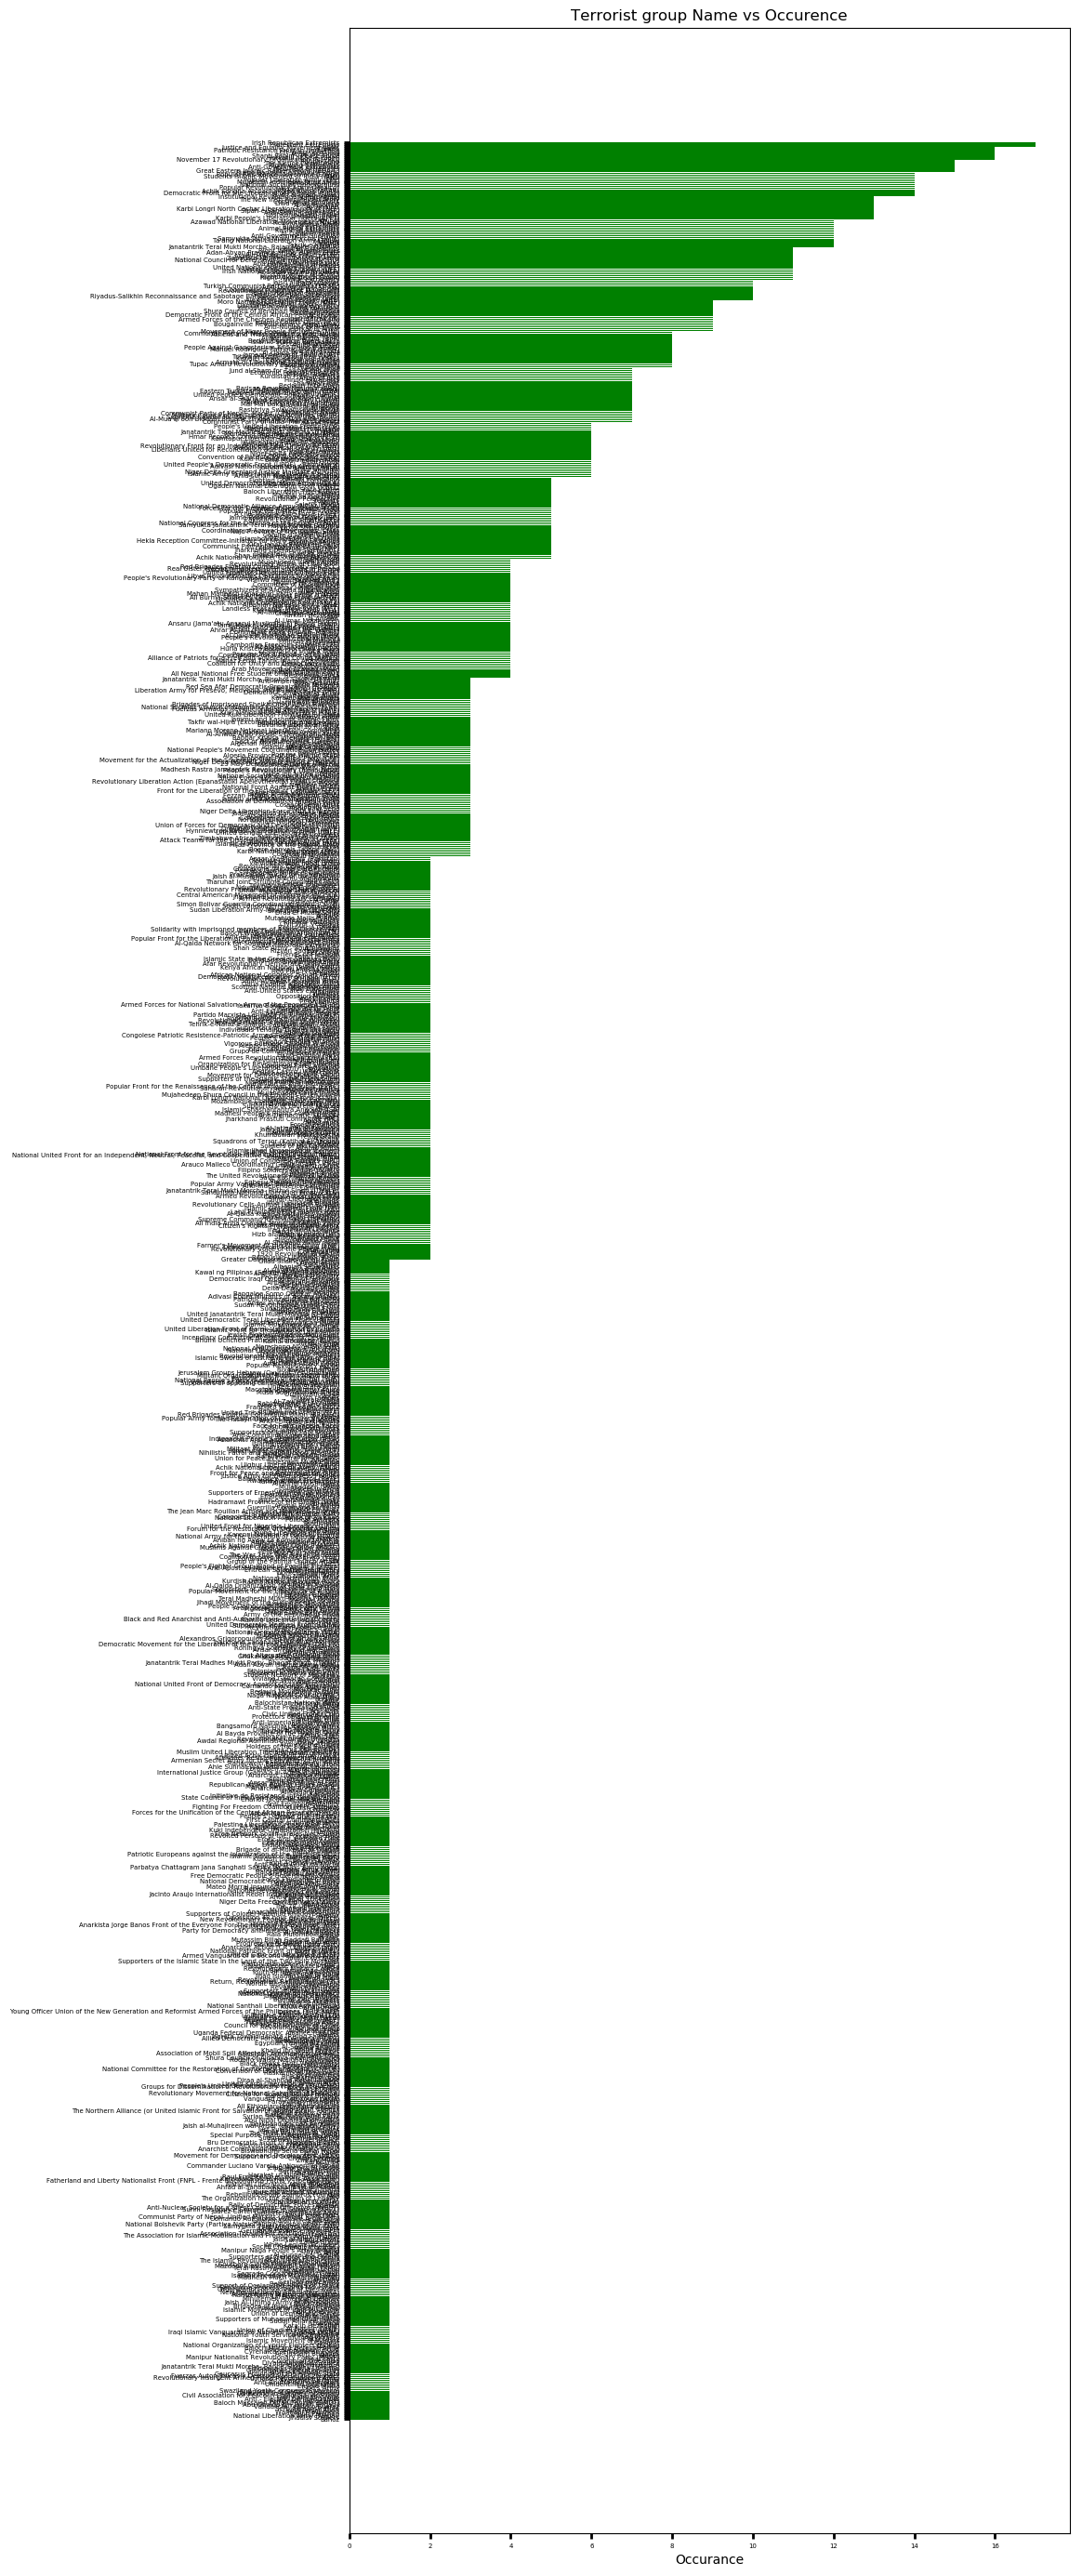

In [593]:
np.random.seed(19680801) # Fixing random state for reproducibility
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,35))
# Example data
plot_list = gname_list[180:]
y_pos = np.arange(len(plot_list))
#error = np.random.rand(len(people))
error = 0
ax.barh(y_pos, occ_list[180:], xerr=error, align='center',
        color='green', ecolor='black')
ax.tick_params(direction='out', length=4, width=2, labelsize = 5, colors='black',
               grid_color='r', grid_alpha=0.5)
#ax.set_xbound(0,5)
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_list)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Occurance')
ax.set_title('Terrorist group Name vs Occurence')

plt.show()

# Model Accuracy vs. Occurence Threshold:

We realized that there were many group labels with just one occurence, we definitley needed to scrap those, because it is certain they will cause errors. what is meant by that more explicitly is that, if we only have a label with one occurence, it will either end up in the test data set or the train data set. If it ends up in the test data set the model will have no training on this instance and will certainly wrongly predict it's label.

That being said, we can discard the group names that only have 1 occurence, but we can also choose to discard group names with "5 or less occurences" because we know the likelihood of a group name with 5 or less occurences all going into either the test section or the train section upon splitting, is a fairly high probablilty. In either case, the accuracy would be affected.

We decide to test out a few thresholds in when we should training/testing ona a label label, we ran the model 4 times in other notebooks, at 4 different thresholds, (with random forest model) being 5, 20, 30 and 40, and we plotted the corresponding accuracies.

here is accuracy vs 'occurence threshold number' line graph scatterplot, we can see accuracy increases as we make our threshold higher, which makes sense because a model trained on more data for a certain group, will have higher accuracy at being able to predict that group if the group came up in the test set.

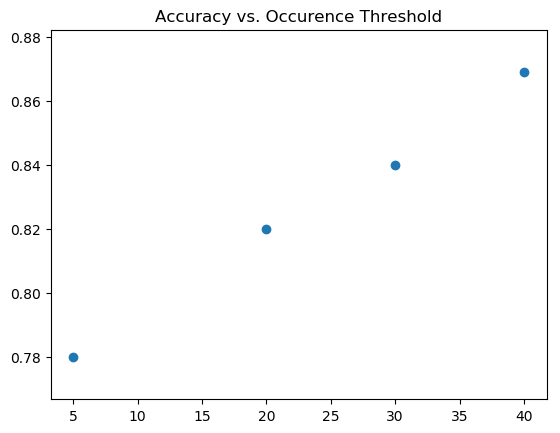

In [594]:
x = [5, 20, 30, 40] # various threshold values
y = [0.78, 0.82, 0.84, 0.869]
fig, ax = plt.subplots()
plt.scatter(x, y) 
plt.title('Accuracy vs. Occurence Threshold')
plt.show()
fig.savefig('accuracy.png')

#### Applying the threshold:

Ideally I actually wanted to keep threshold at 5 and then apply some over sampling techniques to really deal with the imbalance, but once I implemented 5 as the threshold and tried to perform over sampling, the computation took too long and would burn out my kernel, heat up my computer, run out of memory, etc. 

Some form of parallelization should be implemented for this, wheather it be using spark and AWS, or maybe it can be spawning multiple requests at a time utilizing multiple core's in a CPU. 

In [595]:
threshold = 40 
group_names = value_list[value_list.values > threshold].index 
values = list(value_list[value_list.values > threshold])

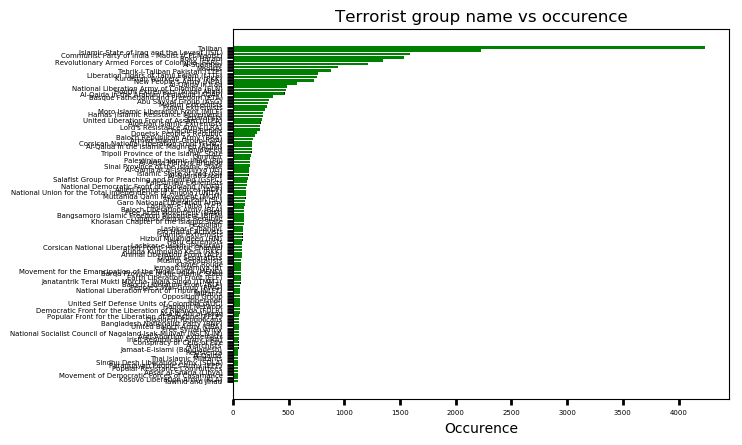

In [596]:
import matplotlib.pyplot as plt
import numpy as np

plot_list = list(group_names)
# Fixing random state for reproducibility
np.random.seed(19680801)
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(plot_list))
error = np.random.rand(len(plot_list))
ax.barh(y_pos, values, xerr=error, align='center',
        color='green', ecolor='black')
ax.tick_params(direction='out', length=4, width=2, labelsize = 5, colors='black',
               grid_color='r', grid_alpha=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_list)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Occurence')
ax.set_title('Terrorist group name vs occurence')

plt.show()

### Note: We are dealing with unbalanced datasets
We can try to use some packages like SMOTE or imbalanced classes but in general tree based algorithms handle imbalanced classes better

# 3. PREPROCESSING TEXT

In [597]:
df['summary']

0                                                                                                                                                                                                               
1                                                                                                                                                                                                               
2                                                                                                                                                                                                               
3                                                                                                                                                                                                               
4                                                                                                                                                                   

In [598]:
#preprocessing
summarydate_list = []
body_list = []

for i in range(0,len(df)):
    s = df['summary'][i]
    summarydate_list.append(s[:s.find(':')])
    body_list.append(s[s.find(':'):])

#df['summarydate'] = summarydate_list
df['summary'] = body_list

In [599]:
df['summary'] = [string.replace(":", " ") for string in df['summary']]

In [600]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def stripp(s): #function stripping punctuation
    exclude = set(string.punctuation)
    s = ''.join(ch for ch in s if ch not in exclude)
    return s

# lowering and stripping punc. from df['summary']
df['summary'] = [item.lower() for item in df['summary']]
df['summary'] = [stripp(item) for item in df['summary']]
df['summary'] = [remove_special_characters(item, remove_digits = True) for item in df['summary']]


In [601]:
group_names1 = [item.lower() for item in group_names]
group_names1 = [stripp(item) for item in group_names1]

In [602]:
newbody_list = []

for item1 in df['summary']:
    summ = str(item1)
    for item2 in group_names1:
        gname = str(item2) 
        if gname in summ:
            summ = summ.replace(gname, " ") 
    newbody_list.append(summ) #for every group appending to list
    
df['summary'] = newbody_list

In [603]:
df['summary'].head()

0    
1    
2    
3    
4    
Name: summary, dtype: object

In [604]:
#examples where it worked
df['summary'][34095], df['summary'][34095], 

('  assailants opened fire on cuper banugan at his residence in poblacion neighborhood caraga davao oriental philippines at least two people including banugan a mandaya tribal chieftain were killed in the assault the   claimed responsibility for the attack',
 '  assailants opened fire on cuper banugan at his residence in poblacion neighborhood caraga davao oriental philippines at least two people including banugan a mandaya tribal chieftain were killed in the assault the   claimed responsibility for the attack')

In [605]:
df['summary'][34091] #where it didnt work...

'  a suicide bomber detonated near counter terrorism department ctd officials in shafi town neighborhood rahim yar khan punjab pakistan aside from the death of the bomber at least two officials were injured in the blast the   claimed responsibility for the attack sources also suspected that the incident may have been carried out by   tehriki  pakistan ttp ahle sunnat wal jamaat aswjpakistan and jundallah'

###### bugs or limitations?
Though some group names are still present in our unstructured data, we can hope that most of the group names are filtered out. Further sophisticated preproccessing is neccessary, for now we will consider this a limitiation or "bug" of our model and move on. 

For the future I would try collecting all the possible names that I can manually find that still remain, put them in a list, and perform a second filtering step to filter those out, though surley some more sophisticated more pythonic techniques exist and can/should be investigated.

In [606]:
df['summary'] = [simple_stemmer(item) for item in df['summary']]
# lowering and stripping punc. from initial group_names, 
# saving as group_names1 to be used in matching 
# with the stemming this will reduce the number of features by combining words

In [607]:
df =  df[df['gname'].isin(group_names)] 
Counter(type(item) for item in df['summary'])

Counter({str: 28404})

# 4. FEATURE ENGINEERING / STRUCTURED MODELING

### MODELING PHILOSOPHY: 
in general this notebook and workflow will take on the following modeling schema: to start with simple models first and then increase in complexity. We first start with logistic regression and naive bayes and then move up to tree based models like decision tree and random forest.

 Let it be noted that SVM (support vector machines) and Knn classfier (K-nearest neighbors) were also attempted, and for some reason caused the kernel to die and run out of memory so some parallelization should be implemeted in the future to use these models.

##### Back to Feature engineering:
we will investigate teh features by hand a bit and look at the data types.

crit1, crit2, crit3, value counts comes in handy here

In [608]:
df['crit1'].value_counts()

1    22935
1     5468
0        1
Name: crit1, dtype: int64

In [609]:
df['crit2'].value_counts()

1    25545
1     2859
Name: crit2, dtype: int64

In [610]:
df['crit3'].value_counts()

1    27062
1     1342
Name: crit3, dtype: int64

We could see that most of these crit values will not have any feature importance on the model since they are all consisting of the same value '1', regardless of their data type

we will now look at the data types of all the features in general

In [611]:
cols = list(df.columns)
for item1 in cols:
    print(Counter([type(item) for item in df[item1]]), item1)

Counter({<class 'numpy.float64'>: 28404}) eventid
Counter({<class 'numpy.int64'>: 28404}) iyear
Counter({<class 'numpy.int64'>: 28404}) imonth
Counter({<class 'numpy.int64'>: 28404}) iday
Counter({<class 'float'>: 26663, <class 'str'>: 1741}) approxdate
Counter({<class 'numpy.int64'>: 28404}) extended
Counter({<class 'float'>: 27864, <class 'str'>: 540}) resolution
Counter({<class 'numpy.int64'>: 28404}) country
Counter({<class 'str'>: 28404}) country_txt
Counter({<class 'numpy.int64'>: 28404}) region
Counter({<class 'str'>: 28404}) region_txt
Counter({<class 'str'>: 27984, <class 'float'>: 420}) provstate
Counter({<class 'str'>: 28314, <class 'float'>: 90}) city
Counter({<class 'numpy.float64'>: 28404}) latitude
Counter({<class 'numpy.float64'>: 28404}) longitude
Counter({<class 'numpy.float64'>: 28404}) specificity
Counter({<class 'numpy.int64'>: 28404}) vicinity
Counter({<class 'float'>: 16688, <class 'str'>: 11716}) location
Counter({<class 'str'>: 28404}) summary
Counter({<class '

#### upon examining this list we see that we should filter the appropriate columns as done in the line below. we do this because we want the datat to be consistent and of the same type throughout. further data engineering would need to be done to make other columns uniform, so we will see how our model fares using these already uniform features.

we see that the following features have the homogenous data types that can be dealt with

In [612]:
df = df.filter(items = ['country_txt', 'region_txt', 'provstate', 'city', 'location', 'suicide',
                        'attacktype1', 'targtype1_txt', 'targsubtype_txt', 'corp1','summary', 'gname'])

In [613]:
cat_List = ['country_txt', 'region_txt', 'provstate', 'city', 'suicide',
           'attacktype1', 'targtype1_txt', 'corp1','gname']

### 4.1  Feature Engineering: one hot encoding

The classification models that require one hot encoding as features would be, logistic regression, K-nearest neighbors classifier, and naive bayes classifier. In general we try models out in increasing order of complexity, knn, then naive bayes, then logistic regression. 

In [614]:
dummy_features = pd.get_dummies(df[cat_List])

In [615]:
dummy_features.shape, len(dummy_features), len(dummy_features.columns)

((28404, 18602), 28404, 18602)

In [616]:
dummy_features = pd.get_dummies(df[['country_txt','provstate','targtype1_txt']])

In [617]:
len(dummy_features), len(dummy_features.columns)

(28404, 995)

In [618]:
y = np.array([str(item) for item in df['gname']])
#make sure that the y is names and not label encoded, but basically only the features need hot encoded 
features= dummy_features 
feature_list = list(dummy_features.columns) #this way we remeber the column names # Convert to numpy array
X_dummies = np.array(dummy_features) #because once we convert to np array it drops the names

### NOW: MODELING ON SOLEY THE STRUCTURED DATA

#### 4.2 Logistic Regression

In [619]:
Xdum1_train, Xdum1_test, Y_train, Y_test = train_test_split(X_dummies, y, test_size = 0.25, random_state = 42)
lr = LogisticRegression(penalty='l2', max_iter=100, C=1) # penalty parameter and C parameter can be tuned

lr_predictions = meu.train_predict_model(classifier=lr, 
                                             train_features=Xdum1_train, train_labels=Y_train,
                                             test_features=Xdum1_test, test_labels=Y_test)

get_metrics(true_labels=Y_test, predicted_labels=lr_predictions)

Accuracy: 0.7923
Precision: 0.7646
Recall: 0.7923
F1 Score: 0.7656


/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 4.3 Feature engineering: label encoding 

In [620]:
for col in cat_List:
    df[col] = df[col].astype('category') #type coersion to category categorical data dypte 
    #forcing to be not continous data.. 
    
cat_columns = df.select_dtypes(['category']).columns 
df2 = df[cat_columns].apply(lambda x: x.cat.codes) #makes it numbers

In [621]:
y = np.array([str(item) for item in df['gname']])  # THIS IS THE LINE THAT GOT RID OF 
                                                    # the error: WEIGHTS NOT SUMMING TO ZERO
# Remove the labels from the features axis 1 refers to the columns
features= df2.drop(['gname'], axis = 1) 
feature_list = list(features.columns) #this way we remeber the column names
X_cat = np.array(features) #because once we convert to np array it drops the names

#### 4.4 Random Forest 

In [622]:
# perfroming test train split on just the structured data
Xcat_train, Xcat_test, Y_train, Y_test = train_test_split(X_cat, y, test_size = 0.25, random_state = 42)

In [623]:
clf = RandomForestClassifier(random_state=0)
clf.fit(Xcat_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [624]:
len(clf.feature_importances_),len(feature_list)

(8, 8)

In [625]:
feature_list

['country_txt',
 'region_txt',
 'provstate',
 'city',
 'suicide',
 'attacktype1',
 'targtype1_txt',
 'corp1']

In [626]:
clf.feature_importances_

array([ 0.30810942,  0.13596396,  0.17616566,  0.12580512,  0.00759909,
        0.04734267,  0.0672858 ,  0.13172827])

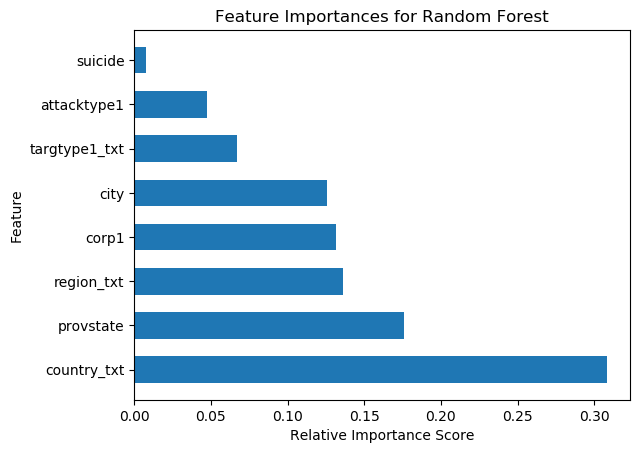

In [627]:
feat_import = clf.feature_importances_
feature_names, feature_scores = zip(*sorted(zip(feature_list, feat_import), 
                                                          key=lambda x: -x[1]))
feature_names = feature_names[:10]
feature_scores = feature_scores[:10]
y_position = list(range(len(feature_names)))
plt.barh(y_position, feature_scores, height=0.6, align='center')
plt.yticks(y_position , feature_names)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Random Forest')
plt.show()

In [628]:
from sklearn import metrics
true_labels = Y_test
predicted_labels = clf.predict(Xcat_test)

clf_predictions = meu.train_predict_model(classifier=clf, 
                                             train_features=Xcat_train, train_labels=Y_train,
                                             test_features=Xcat_test, test_labels=Y_test)

get_metrics(true_labels=Y_test, predicted_labels=lr_predictions)

Accuracy: 0.7923
Precision: 0.7646
Recall: 0.7923
F1 Score: 0.7656


/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [629]:
Xcat_train_df = pd.DataFrame(Xcat_train)
Xcat_test_df = pd.DataFrame(Xcat_test)

# 5. Modeling with added features of unstructured text data for Naive Bayes Classifier and Logistic Regression

There are two ways to represent the text data in vectors. one being "bag of words" and one being "tfidf". We try each model with our text data in both vector representations of "bag of words" and "tfidf", and compare the two outcomes. 

##### We well analyze the ROC curve of each classification after every model is run to gain more insight, especially insight on the behavior of the poorest performing class. Also we will comment out the line to "display legend" in our function definition displaying the ROC curve because we have over 100 classes. 

Now, to build our vocabulary for Bag-of-Words and TFIDF we must obtain the min df

## 5.1 obtaining min df:

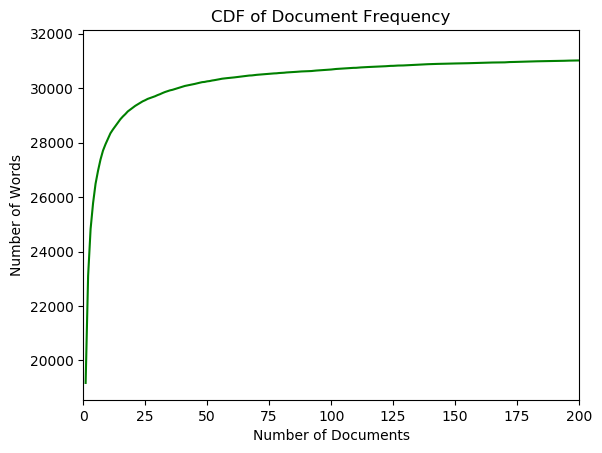

In [630]:
# this cell is to get min df:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0)

X = vectorizer.fit_transform(df['summary']) #train it almost to create your vocab. call fit to build vocab
X = X.toarray()

# Get the counts of documents each word appears on 
count = []
for i in range(X.shape[1]):
    x = np.count_nonzero(X[:, i])
    count.append(x)
count = np.sort(count)

# Constructing X and Y axis
ind = [] #number of words
val = [] #number of documents
for i in np.arange(len(count)):
    if i != len(count)-1:
        if count[i] < count[i+1]:
            ind.append(i+1)
            val.append(count[i])
    else:
        ind.append(len(count))
        val.append(count[i])

# Plot the graph
plt.plot(val, ind, color='green')
plt.xlabel('Number of Documents')
plt.ylabel('Number of Words')
plt.title('CDF of Document Frequency')
plt.xlim(0, 200)
plt.show()

From this graph we see min df should be about 5. We want to choose our min df around when we would start to see the graph plateuing. If you make mindf too small then it will care about words that only exist in 1 document and if you make min df too large it will care about words that are in all of the documents, where we do not want to add words that are in all of the documents because then the feature wont be as indicative.

## 5.2 begining to combine structured and unstructured data for naive bayes and logistic regression: 
naive bayes classifier, logistic regression, both need to use one-hot encoding feature engineering, can be easily done with pandas as seen above in 4.1 in the line --> pd.get_dummies(df[cat_List]). 

Here we put X_dummies,X_summ, and y, through the test train split and then merge them later

In [631]:
X_summ = np.array(df['summary'])

In [632]:
Xdum_train, Xdum_test, Xsumm_train, Xsumm_test, Y_train, Y_test = train_test_split(X_dummies,X_summ, y, test_size = 0.25, random_state = 42)

In [633]:
# CONSTRUCTING COMBINED FEATURES AFTER THE SPLIT
# Xbow : will combine structured data with Bag of Words vectors
# Xtf : will combine structured data with TFIDF vectors

vectorizer = CountVectorizer(min_df=5)
#tvectorizer = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,1), sublinear_tf=True)
tvectorizer = TfidfVectorizer(min_df=5)

Xbow_train_features = vectorizer.fit_transform(Xsumm_train) #train it almost to create your vocab. call fit to build vocab
Xbow_train_features = Xbow_train_features.toarray()
Xbow_train_df = pd.DataFrame(Xbow_train_features)

Xtf_train_features = tvectorizer.fit_transform(Xsumm_train) #train it almost to create your vocab. call fit to build vocab
Xtf_train_features = Xtf_train_features.toarray()
Xtf_train_df = pd.DataFrame(Xtf_train_features)
#

Xbow_test_features = vectorizer.transform(Xsumm_test) #difference betweeen transform and fit trans
#train it almost to create your vocab. call fit to build vocab
Xbow_test_features = Xbow_test_features.toarray()
Xbow_test_df = pd.DataFrame(Xbow_test_features)

Xtf_test_features = tvectorizer.transform(Xsumm_test) #difference betweeen transform and fit trans
#train it almost to create your vocab. call fit to build vocab
Xtf_test_features = Xtf_test_features.toarray()
Xtf_test_df = pd.DataFrame(Xtf_test_features)

In [634]:
Xbow_train_features.shape, Xtf_train_features.shape, Xbow_test_features.shape, Xtf_test_features.shape

((21303, 4824), (21303, 4824), (7101, 4824), (7101, 4824))

In [635]:
#MAKING XDUM TO MERGE
Xdum_train_df = pd.DataFrame(Xdum_train)
Xdum_test_df = pd.DataFrame(Xdum_test)

#### Then concatenating:
- first the two TRAIN sets for both [structured data  w/ bag of words features] and [struct data  w/ tfidf features] 

- and then the two TEST sets for both [structured data  w/ bag of words features] and [struct data  w/ tfidf features] 

- Xdum_train_df with Xbow_train_df and Xdum_train_df with Xtf_train_df

- Xdum_test_df with Xbow_test_df and Xdum_test_df with Xtf_test_df

In [636]:
mega_train_df = pd.concat([Xdum_train_df, Xbow_train_df], axis = 1)

megatf_train_df = pd.concat([Xdum_train_df, Xtf_train_df], axis = 1)

mega_test_df = pd.concat([Xdum_test_df, Xbow_test_df], axis = 1)
megatf_test_df = pd.concat([Xdum_test_df, Xtf_test_df], axis = 1)

In [637]:
mega_train_df.shape, mega_test_df.shape, megatf_train_df.shape, megatf_test_df.shape 

((21303, 5819), (7101, 5819), (21303, 5819), (7101, 5819))

In [638]:
# Xbow_mega_train: "bow" refers to bag of words
# Xtf_mega_train: "tf" refers to tfidf features 

Xbow_mega_train = np.array(mega_train_df)
Xbow_mega_test = np.array(mega_test_df)

Xtf_mega_train = np.array(megatf_train_df)
Xtf_mega_test = np.array(megatf_test_df)

In [639]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn import neighbors, datasets

lr = LogisticRegression(penalty='l2', max_iter=100, C=1) # penalty parameter and C parameter can be tuned
svm = SGDClassifier(loss='hinge', n_iter=100) #stochastic gradient descent svm
knn=neighbors.KNeighborsClassifier()

from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [640]:
Xbow_mega_train.shape, Y_train.shape, Xbow_mega_test.shape, Y_test.shape

((21303, 5819), (21303,), (7101, 5819), (7101,))

In [641]:
Xtf_mega_train.shape, Y_train.shape, Xtf_mega_test.shape, Y_test.shape

((21303, 5819), (21303,), (7101, 5819), (7101,))

In the cell below we oversample our training set, which we can use for all models that take the one hot encoded features (these models being logistic regression and naive bayes classification) but we will first check performance metrics on the un-sampled data and then compare performance metrics with the oversampled data.

In [642]:
# warning: takes ~8 minutes to run this cell, but it runs!

# HERE: DEFINING X_Xbow_train_res and Y_train_res
# FOR OVERSAMPLING THE SMALLER CLASSES
# ON ONE HOT ENCODING AND BOW FEATURES

imbalanced_labels = dict(Counter(Y_train))

for i,j in imbalanced_labels.items():
    #print(i, j)
    if j < 200:
        imbalanced_labels[i] = 200
        
from imblearn.over_sampling import SMOTE
sm = SMOTE(ratio = imbalanced_labels, random_state=42)
Xbow_train_res, Y_train_res = sm.fit_sample(Xbow_mega_train, Y_train)

and now for oversampling the TFIDF combined DataFrame (known as Xtf_mega_train). Note: we only perform resampling on the traing data

In [643]:
Xtf_train_res, Y_train_res = sm.fit_sample(Xtf_mega_train, Y_train)

In [644]:
Xbow_train_res.shape, Y_train_res.shape, Xtf_train_res.shape, Y_train_res.shape

((31483, 5819), (31483,), (31483, 5819), (31483,))

good! they are the same in shape

## 5.3 Naive Bayes multi-class Classifier with bag of words:

Here we will first check performance of naive bayes classifer on non-sampled data,checking our metrics and our ROC curve.

In [645]:
# naive bayes model on bow features
nb_predictions = meu.train_predict_model(classifier=nb, 
                                             train_features=Xbow_mega_train, train_labels=Y_train,
                                             test_features=Xbow_mega_test, test_labels=Y_test)

get_metrics(true_labels=Y_test, predicted_labels=nb_predictions)

Accuracy: 0.8244
Precision: 0.8072
Recall: 0.8244
F1 Score: 0.7952


/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [646]:
Xbow_mega_test.shape, Y_test.shape

((7101, 5819), (7101,))

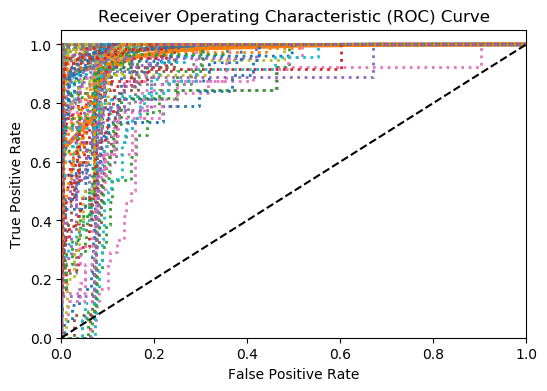

In [647]:
#ROC CURVE:
plot_model_roc_curve(nb, Xbow_mega_test, Y_test)

#### naive bayes resampling

In [648]:
# naive bayes model on bow features
nb_predictions = meu.train_predict_model(classifier=nb, 
                                             train_features=Xbow_train_res, train_labels=Y_train_res,
                                             test_features=Xbow_mega_test, test_labels=Y_test)

get_metrics(true_labels=Y_test, predicted_labels=nb_predictions)

Accuracy: 0.8773
Precision: 0.8813
Recall: 0.8773
F1 Score: 0.8718


 Notice we feed the same Xbow_mega_test, Y_test in as for unsampled modeling
     
 because resampling only applied to training data when training model

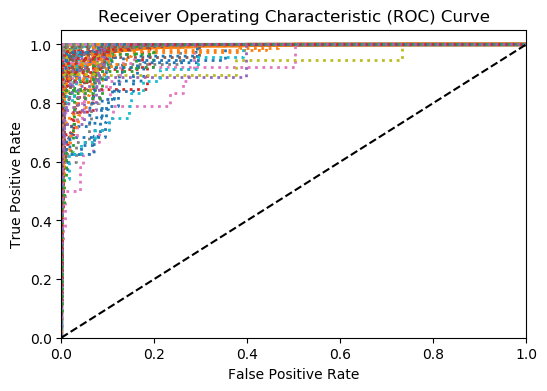

In [649]:
#ROC CURVE:
plot_model_roc_curve(nb, Xbow_mega_test, Y_test) 

##### To summarize: for naive bayes classifier on structured data with bag of words feature: oversampling brought accuracy up from 0.82 to 0.87! Resampling worked well on this model.

## 5.4 Naive bayes with structured and tfidf features:
we will conduct the same procedure from above (un-sampled and over-sampled performance) for the Naive bayes classifier on structured data and tfidf features.

In [650]:
# naive bayes model on tfidf features
nbtf_predictions = meu.train_predict_model(classifier=nb, 
                                             train_features=Xtf_mega_train, train_labels=Y_train,
                                             test_features=Xtf_mega_test, test_labels=Y_test)

get_metrics(true_labels=Y_test, predicted_labels=nbtf_predictions)

Accuracy: 0.7744
Precision: 0.7612
Recall: 0.7744
F1 Score: 0.725


/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


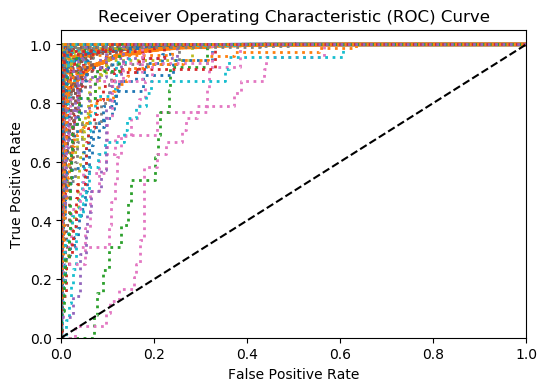

In [651]:
#ROC CURVE:
plot_model_roc_curve(nb, Xtf_mega_test, Y_test)

In [652]:
# naive bayes model on bow features
nbtfres_predictions = meu.train_predict_model(classifier=nb, 
                                             train_features=Xtf_train_res, train_labels=Y_train_res,
                                             test_features=Xtf_mega_test, test_labels=Y_test)

get_metrics(true_labels=Y_test, predicted_labels=nbtfres_predictions)

Accuracy: 0.8354
Precision: 0.8427
Recall: 0.8354
F1 Score: 0.8102


/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


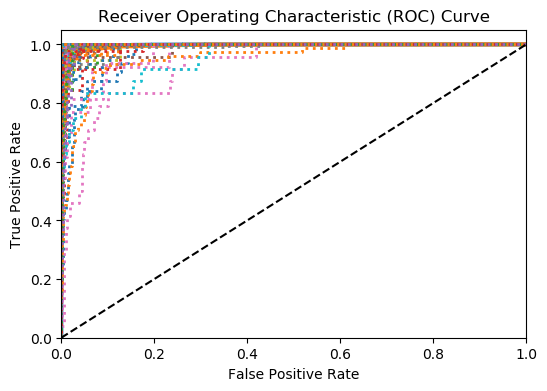

In [653]:
#ROC CURVE:
plot_model_roc_curve(nb, Xtf_mega_test, Y_test)

##### to summarize: For NAIVE BAYES Classifier, our best performance was the:  "structured data and bag of words features with oversampling"

we tried the knn : knn=neighbors.KNeighborsClassifier(), knn.fit(X_mega, Y_train), knn.predict(X_mega_test), but the predict took to long and made computer heat up... :/

## 5.5 Logistic regression with Bag-of-words

In [654]:
# Logistic Regression model on bow features
lr_predictions = meu.train_predict_model(classifier=lr, 
                                             train_features=Xbow_mega_train, train_labels=Y_train,
                                             test_features=Xbow_mega_test, test_labels=Y_test)

get_metrics(true_labels=Y_test, predicted_labels=lr_predictions)

Accuracy: 0.9235
Precision: 0.9262
Recall: 0.9235
F1 Score: 0.9215


this has high Accuracy! but its the roc curve which will tell us the specifics.

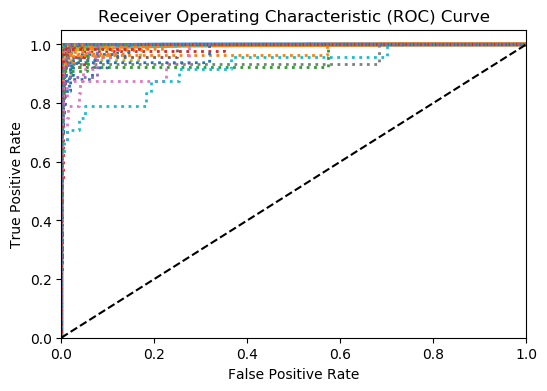

In [655]:
plot_model_roc_curve(lr, Xbow_mega_test, Y_test)

now with oversampling

In [656]:
# Logistic Regression model on bow features with over sampling
lr_res_predictions = meu.train_predict_model(classifier=lr, 
                                             train_features=Xbow_train_res, train_labels=Y_train_res,
                                             test_features=Xbow_mega_test, test_labels=Y_test)

get_metrics(true_labels=Y_test, predicted_labels=lr_predictions)

Accuracy: 0.9235
Precision: 0.9262
Recall: 0.9235
F1 Score: 0.9215


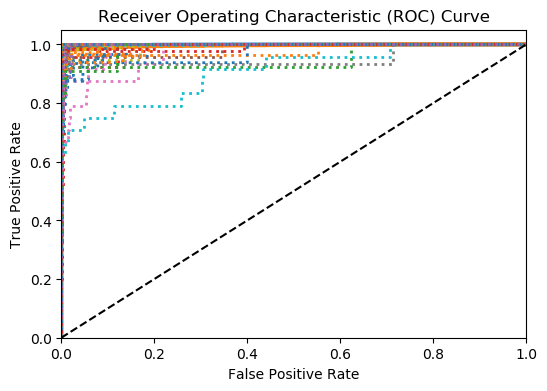

In [657]:
# show roc curve 
plot_model_roc_curve(lr, Xbow_mega_test, Y_test) # Notice we feed the same in as for unsampled
                                                 # because resampling only affects our training of the lr model 

Interesting the oversampling slightly decreased the accuracy.

In [658]:
# LOGISTIC REGRESSION WITH OVERSAMPLING THE SMALLER CLASSES
# TFIDF FEATURES ...NO, wont do that

## 5.6 Logistic regression with tfidf

In [659]:
# Logistic Regression model on features
lrtf_predictions = meu.train_predict_model(classifier=lr, 
                                             train_features=Xtf_mega_train, train_labels=Y_train,
                                             test_features=Xtf_mega_test, test_labels=Y_test)
get_metrics(true_labels=Y_test, predicted_labels=lrtf_predictions)

Accuracy: 0.8997
Precision: 0.9012
Recall: 0.8997
F1 Score: 0.892


/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


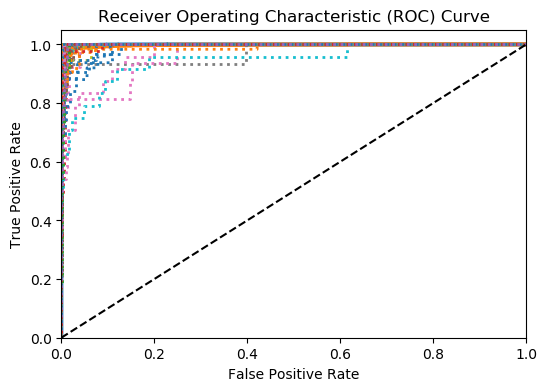

In [660]:
plot_model_roc_curve(lr, Xtf_mega_test, Y_test)

Logistic regression with tftidf is good, but not as good as logistic regression with Bag-of-Words. We can still try the resampled data.

In [661]:
# Logistic Regression model on bow features with over sampling
lr_res_predictions = meu.train_predict_model(classifier=lr, 
                                             train_features=Xtf_train_res, train_labels=Y_train_res,
                                             test_features=Xtf_mega_test, test_labels=Y_test)
get_metrics(true_labels=Y_test, predicted_labels=lr_res_predictions)

Accuracy: 0.9038
Precision: 0.9076
Recall: 0.9038
F1 Score: 0.9027


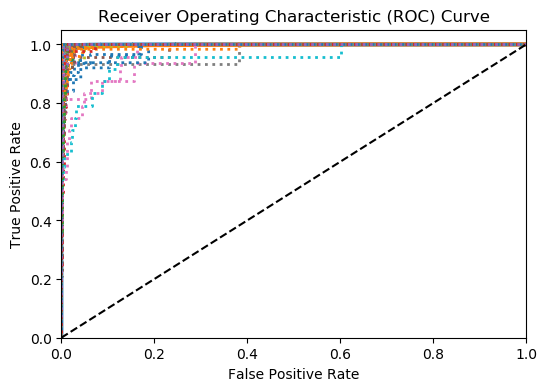

In [662]:
plot_model_roc_curve(lr, Xtf_mega_test, Y_test) # Notice we feed the same in as for unsampled

we saw that we improved with rasmpling on tfidf features

# 6. Combining structured and unstructured data for : decision tree, random forest, using label encoding

#### 6.1 setting up features using label encoding and conducting test train split 

In [663]:
df_cat = df2.drop(['gname'], axis = 1) 
X_cat = np.array(df_cat)

In [664]:
len(X_cat),len(X_summ), len(df['summary'])

(28404, 28404, 28404)

In [665]:
Xcat_train, Xcat_test, Xbow_train, Xbow_test, Y_train, Y_test = train_test_split(X_cat,X_summ, y, test_size = 0.25, random_state = 42)

In [666]:
# CONSTRUCTING BOW AND TFIDF FEATURES AFTER THE SPLIT
vectorizer = CountVectorizer(min_df=5)
tvectorizer = TfidfVectorizer(min_df=5)

Xbow_train_features = vectorizer.fit_transform(Xsumm_train) #train it almost to create your vocab. call fit to build vocab
Xbow_train_features = Xbow_train_features.toarray()
Xbow_train_df = pd.DataFrame(Xbow_train_features)

Xtf_train_features = tvectorizer.fit_transform(Xsumm_train) #train it almost to create your vocab. call fit to build vocab
Xtf_train_features = Xtf_train_features.toarray()
Xtf_train_df = pd.DataFrame(Xtf_train_features)

Xbow_test_features = vectorizer.transform(Xsumm_test) #difference betweeen transform and fit trans
#train it to create your vocab. call fit to build vocab
Xbow_test_features = Xbow_test_features.toarray()
Xbow_test_df = pd.DataFrame(Xbow_test_features)

Xtf_test_features = tvectorizer.transform(Xsumm_test) #difference betweeen transform and fit trans
#train it to create your vocab. call fit to build vocab
Xtf_test_features = Xtf_test_features.toarray()
Xtf_test_df = pd.DataFrame(Xtf_test_features)

In [667]:
# MAKING XCAT TO MERGE
Xcat_train_df = pd.DataFrame(Xcat_train)
Xcat_test_df = pd.DataFrame(Xcat_test)

#### Then concatenating:
- first the two TRAIN sets for both [structured data  w/ bag of words features] and [struct data  w/ tfidf features] 

- and then the two TEST sets for both [structured data  w/ bag of words features] and [struct data  w/ tfidf features] 

- Xcat_train_df with Xbow_train_df and Xcat_train_df with Xtf_train_df

- Xcat_test_df with Xbow_test_df and Xcat_test_df with Xtf_test_df

In [668]:
mega_train_df = pd.concat([Xcat_train_df, Xbow_train_df], axis = 1)
mega_test_df = pd.concat([Xcat_test_df, Xbow_test_df], axis = 1)

megatf_train_df = pd.concat([Xcat_train_df, Xtf_train_df], axis = 1)
megatf_test_df = pd.concat([Xcat_test_df, Xtf_test_df], axis = 1)

In [669]:
mega_train_df.shape, mega_test_df.shape, megatf_train_df.shape, megatf_test_df.shape 

((21303, 4832), (7101, 4832), (21303, 4832), (7101, 4832))

In [670]:
Xbow_mega_train = np.array(mega_train_df)
Xbow_mega_test = np.array(mega_test_df)

Xtf_mega_train = np.array(megatf_train_df)
Xtf_mega_test = np.array(megatf_test_df)

In [671]:
Xbow_mega_train.shape, Y_train.shape, Xbow_mega_test.shape, Y_test.shape

((21303, 4832), (21303,), (7101, 4832), (7101,))

In [672]:
Xtf_mega_train.shape, Y_train.shape, Xtf_mega_test.shape, Y_test.shape

((21303, 4832), (21303,), (7101, 4832), (7101,))

Now for our resampling (Resampled Bag of words features)

In [675]:
# warning: takes ~8 minutes to run this cell, but it runs!

# HERE: DEFINING X_Xbow_train_res and Y_train_res
# FOR OVERSAMPLING THE SMALLER CLASSES
# ON ONE HOT ENCODING AND BOW FEATURES

imbalanced_labels = dict(Counter(Y_train))

for i,j in imbalanced_labels.items():
    #print(i, j)
    if j < 200:
        imbalanced_labels[i] = 200
        
from imblearn.over_sampling import SMOTE #, ADASYN
sm = SMOTE(ratio = imbalanced_labels, random_state=42)
Xbow_train_res, Y_train_res = sm.fit_sample(Xbow_mega_train, Y_train)

and resampled with TFIDF

In [676]:
Xtf_train_res, Y_train_res = sm.fit_sample(Xtf_mega_train, Y_train)

### 6.2 Random Forest Classifier with Bag of Words:

In [677]:
clf = RandomForestClassifier(random_state=0)

first without resampling

In [678]:
clf_predictions = meu.train_predict_model(classifier=clf, 
                                             train_features=Xbow_mega_train, train_labels=Y_train,
                                             test_features=Xbow_mega_test, test_labels=Y_test)
get_metrics(true_labels=Y_test, predicted_labels=clf_predictions)

Accuracy: 0.8609
Precision: 0.8606
Recall: 0.8609
F1 Score: 0.8533


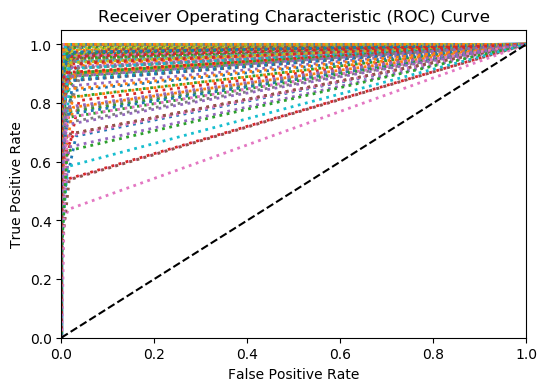

In [679]:
plot_model_roc_curve(clf, Xbow_mega_test, Y_test)

Now Training the model on Imbalanced data

In [680]:
clfRes_predictions = meu.train_predict_model(classifier=clf, 
                                             train_features=Xtf_train_res, train_labels=Y_train_res,
                                             test_features=Xtf_mega_test, test_labels=Y_test)
get_metrics(true_labels=Y_test, predicted_labels=clf_predictions)                                       

Accuracy: 0.8609
Precision: 0.8606
Recall: 0.8609
F1 Score: 0.8533


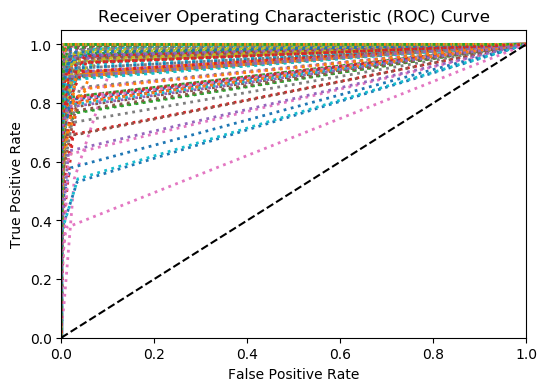

In [681]:
plot_model_roc_curve(clf, Xbow_mega_test, Y_test)

##### boosted accuracy about 0.05 with oversampling.

In [682]:
clf_predictions = meu.train_predict_model(classifier=clf, 
                                             train_features=Xtf_mega_train, train_labels=Y_train,
                                             test_features=Xtf_mega_test, test_labels=Y_test)
get_metrics(true_labels=Y_test, predicted_labels=clf_predictions)                                       

Accuracy: 0.85
Precision: 0.8491
Recall: 0.85
F1 Score: 0.8415


/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


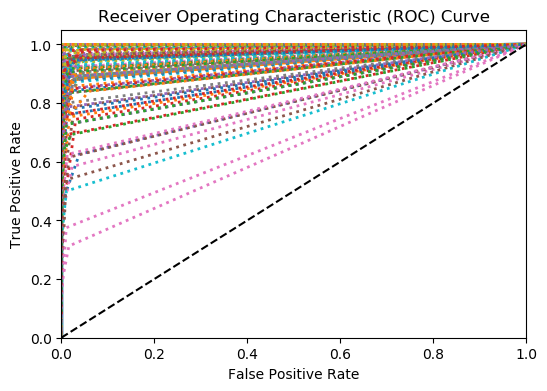

In [683]:
plot_model_roc_curve(clf, Xtf_mega_test, Y_test)

In [684]:
clfRes_predictions = meu.train_predict_model(classifier=clf, 
                                             train_features=Xtf_train_res, train_labels=Y_train_res,
                                             test_features=Xtf_mega_test, test_labels=Y_test)
get_metrics(true_labels=Y_test, predicted_labels=clfRes_predictions)   

Accuracy: 0.8642
Precision: 0.8624
Recall: 0.8642
F1 Score: 0.8587


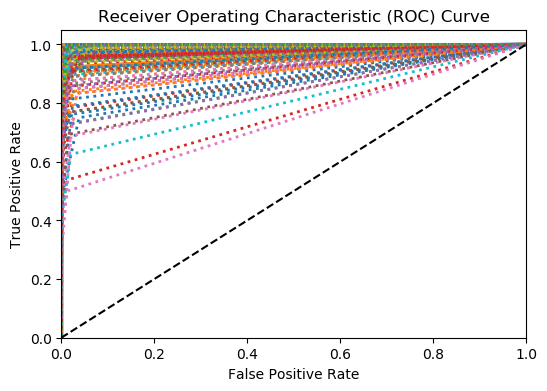

In [685]:
plot_model_roc_curve(clf, Xtf_mega_test, Y_test)

### 6.3 Decision Tree

 actually decision tree looks fairly hopeful!!! for some reason performed better than random forest !!

In [686]:
dtr = tree.DecisionTreeClassifier(random_state=0)

In [687]:
dtr_predictions = meu.train_predict_model(classifier=dtr, 
                                             train_features=Xbow_mega_train, train_labels=Y_train,
                                             test_features=Xbow_mega_test, test_labels=Y_test)
get_metrics(true_labels=Y_test, predicted_labels= dtr_predictions)                                       

Accuracy: 0.8845
Precision: 0.8849
Recall: 0.8845
F1 Score: 0.8831


In [688]:
# dimension sanity checking to debug
Xbow_mega_train.shape, Y_train.shape

((21303, 4832), (21303,))

In [689]:
Xbow_train_res.shape, Y_train_res.shape

((31483, 4832), (31483,))

In [690]:
dtrres_predictions = meu.train_predict_model(classifier=dtr, 
                                             train_features=Xbow_train_res, train_labels=Y_train_res,
                                             test_features=Xbow_mega_test, test_labels=Y_test)
get_metrics(true_labels=Y_test, predicted_labels= dtrres_predictions)  

Accuracy: 0.8811
Precision: 0.8843
Recall: 0.8811
F1 Score: 0.8813


In [691]:
dtrtf_predictions = meu.train_predict_model(classifier=dtr, 
                                             train_features=Xtf_mega_train, train_labels=Y_train,
                                             test_features=Xtf_mega_test, test_labels=Y_test)
get_metrics(true_labels=Y_test, predicted_labels= dtrtf_predictions)                                       

Accuracy: 0.8748
Precision: 0.8775
Recall: 0.8748
F1 Score: 0.8745


In [692]:
dtrtfres_predictions = meu.train_predict_model(classifier=dtr, 
                                             train_features=Xtf_train_res, train_labels=Y_train_res,
                                             test_features=Xtf_mega_test, test_labels=Y_test)
get_metrics(true_labels=Y_test, predicted_labels= dtrtfres_predictions)    

Accuracy: 0.8766
Precision: 0.8817
Recall: 0.8766
F1 Score: 0.8778


## 7. EXPLORING FEATURE IMPORTANCES:

It is fairly easy to plot feature importances of tree-based models because of the categorical style of the data used (it uses label encoding vs one hot encoding) so we went ahead and investigated.

We put this section at the end, to be seen as an annendum, since our best performing model was the logistic regression, and feature importance would be a bit different for that model where we would have many many features of very low importance but all adding as small components to the success of the model. 

In [693]:
lr = LogisticRegression(penalty='l2', max_iter=100, C=1)
lr.fit(Xbow_mega_train, Y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [694]:
print(lr.coef_)

[[  8.01569797e-03  -1.09554076e-01   1.09187665e-03 ...,  -1.17561988e-03
   -3.47995713e-02  -1.70052325e-02]
 [  1.21433617e-02  -1.09789014e+00   2.95880147e-03 ...,  -2.29011420e-03
   -9.89379514e-02  -1.14903805e-02]
 [  1.96725548e-02  -6.55303545e-02  -1.05385427e-01 ...,  -9.51404044e-08
   -1.25357950e-04  -2.20959374e-10]
 ..., 
 [ -5.13878745e-04  -7.12289016e-01  -3.39085156e-03 ...,  -6.10314950e-05
   -8.84227609e-03  -2.19943496e-03]
 [ -1.37672054e-02  -1.68379593e-01  -8.20623436e-03 ...,  -3.28935180e-03
   -2.00660010e-02  -1.37062355e-04]
 [ -3.93803521e-02  -7.86249479e-01  -9.65722072e-05 ...,  -5.04927990e-04
    1.51060432e-01  -4.37305502e-03]]


as we can see, the number of features is very large and each has very low importance. 

clf1 and clf2 are models trained on "bag of words" features and "tfidf" features respectivley

In [695]:
clf1 = RandomForestClassifier(random_state=0)
clf1.fit(Xbow_mega_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [696]:
clf2 = RandomForestClassifier(random_state=0)
clf2.fit(Xtf_mega_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [697]:
len(clf1.feature_importances_), len(clf2.feature_importances_) # ?????? why not the same features

(4832, 4832)

In [698]:
feat_list = list(mega_train_df.columns) #mega train df
feat_listtf = list(megatf_train_df.columns) #mega train df

In [699]:
print(clf1.feature_importances_)
print(clf2.feature_importances_)

[  6.76474809e-02   4.32356913e-02   2.57369743e-02 ...,   1.31849041e-06
   2.37257912e-04   4.38458500e-05]
[  6.50850445e-02   3.21198605e-02   2.95895426e-02 ...,   0.00000000e+00
   1.40484866e-04   6.52264738e-05]


In [700]:
cat_feat = list(df_cat.columns)
bow_feat = list(vectorizer.get_feature_names())
mega_feat_list = cat_feat + bow_feat

tf_feat = list(tvectorizer.get_feature_names())

mega_feat_list = cat_feat + bow_feat
megatf_feat_list = cat_feat + tf_feat

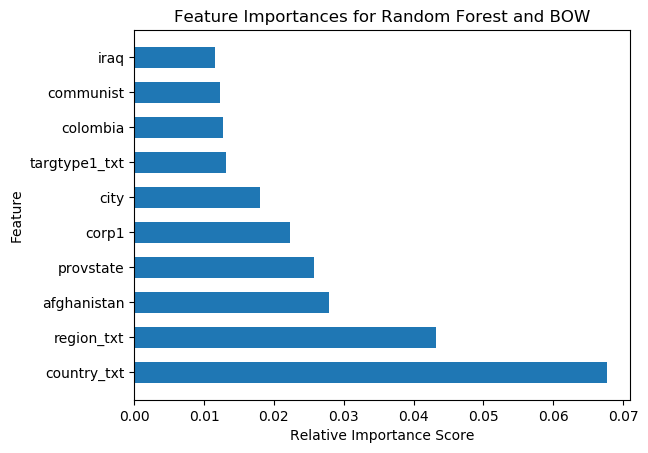

In [701]:
feat_import = clf1.feature_importances_
feature_names, feature_scores = zip(*sorted(zip(mega_feat_list, feat_import), 
                                                          key=lambda x: -x[1]))
feature_names = feature_names[:10]
feature_scores = feature_scores[:10]
y_position = list(range(len(feature_names)))
plt.barh(y_position, feature_scores, height=0.6, align='center')
plt.yticks(y_position , feature_names)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Random Forest and BOW')
plt.show()

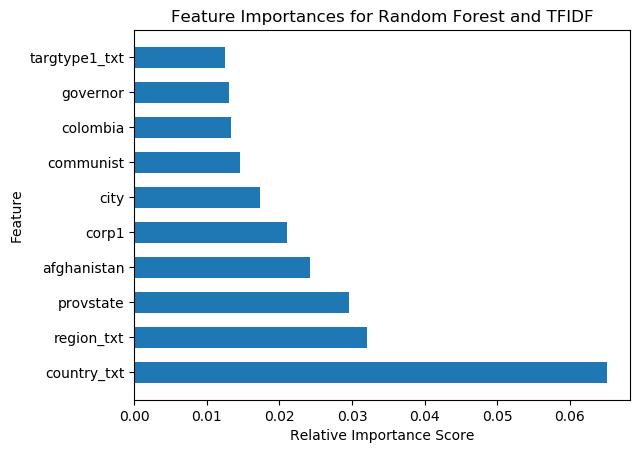

In [702]:
feat_import = clf2.feature_importances_
feature_names, feature_scores = zip(*sorted(zip(megatf_feat_list, feat_import), 
                                                          key=lambda x: -x[1]))
feature_names = feature_names[:10]
feature_scores = feature_scores[:10]
y_position = list(range(len(feature_names)))
plt.barh(y_position, feature_scores, height=0.6, align='center')
plt.yticks(y_position , feature_names)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Random Forest and TFIDF')
plt.show()

# 8. CONCLUSIONS AND FURTHER PLANS:

Overall the best performance, as can be seen by the ROC curves, was the logistic regression without over sampling, which attained an Accuracy of 0.92. in other models like in random forest, decision tree, and naive bayes, the oversampling of the under represented classes increased accuracy. 

For naive bayes classifier on structured data with bag of words feature: oversampling brought accuracy up from 0.82 to 0.87! Resampling worked well on this model. For logistic regression, oversampling brought the accuracy down interestingly enough, but the accuracy had already been at an Accuracy of 0.92 (for bag of words). On Random Forest and decision tree, oversampling brought the accuracy up marginally for both bag of words and tfidf.

In general we noticed the bag of words features performed better than the TFIDF fetaures

Further Plans include implementing possible deep learning and NLP techniques to gain insights and extract new features from the text data, considering we have such an abundant amount of text data, paralellization and scalability of some kind should be implemented. 

## A1. AN EXAMPLE OF A DETAILED MODEL PERFORMANCE REPORT:

### Here we have an example of a detailed performance report where along with entire models accuracy precision recall and f1-score, we can see explicitly the precision, recall, f1-score of each label! this can and should be used when desiring to further investigate the specifics of a model's performance!

In [703]:
clf2_predictions = meu.train_predict_model(classifier=clf2, 
                                             train_features=Xtf_mega_train, train_labels=Y_train,
                                             test_features=Xtf_mega_test, test_labels=Y_test)

meu.display_model_performance_metrics(true_labels=Y_test, predicted_labels=clf2_predictions,
                                      classes=group_names) #they have to match category labels
                                                           #gnames_list

Model Performance metrics:
------------------------------
Accuracy: 0.85
Precision: 0.8491
Recall: 0.85
F1 Score: 0.8415

Model Classification report:
------------------------------
                                                              precision    recall  f1-score   support

                                                     Taliban       0.95      0.99      0.97      1067
                 Islamic State of Iraq and the Levant (ISIL)       0.90      0.97      0.93       566
              Communist Party of India - Maoist (CPI-Maoist)       0.84      0.90      0.87       391
                                                  Boko Haram       0.93      0.99      0.96       375
               Revolutionary Armed Forces of Colombia (FARC)       0.84      0.95      0.89       337
                                                  Al-Shabaab       0.87      1.00      0.93       298
                                                     Maoists       0.75      0.81      0.78       242
 

/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                                                     Predicted:  \
                                                                        Taliban   
Actual: Taliban                                                            1059   
        Islamic State of Iraq and the Levant (ISIL)                           1   
        Communist Party of India - Maoist (CPI-Maoist)                        0   
        Boko Haram                                                            0   
        Revolutionary Armed Forces of Colombia (FARC)                         0   
        Al-Shabaab                                                            0   
        Maoists                                                               2   
        Tehrik-i-Taliban Pakistan (TTP)                                       3   
        Liberation Tigers of Tamil Eelam (LTTE)                               0   
        Kurdistan Workers' Party (PKK)                                        2   
    

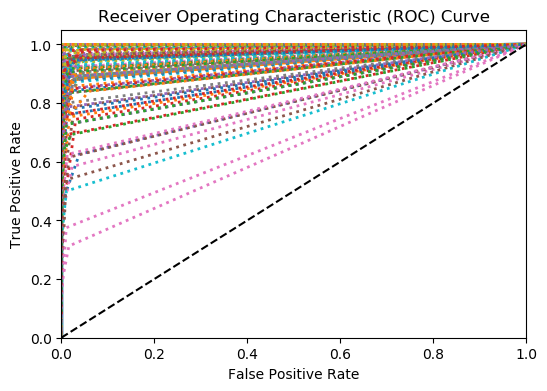

In [704]:
plot_model_roc_curve(clf2, Xtf_mega_test, Y_test)